In [1]:
%load_ext autoreload
%autoreload 2

import os
if not os.getcwd().endswith('BENDR'): os.chdir(os.path.dirname(os.getcwd()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from tqdm import tqdm

import BENDR.utils as utils
from importlib import reload
import BENDR.BENDR_utils as BENDR_utils
reload(BENDR_utils)
from BENDR.BENDR_utils import BENDR
from matplotlib import pyplot as plt
import activation_generator as act_gen
import numpy as np
import tcav as tcav
import tensorflow as tf
import utils_plot

2023-04-11 18:56:24.350552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 18:56:25.898460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
encoder_weights = 'encoder_BENDR.pt'
context_weights = 'contextualizer_BENDR.pt'
classifier_weights = 'classifier_BENDR.pt'

model = BENDR(targets=2, samples=1536, channels=20, device='cuda')
model.load_all(encoder_weights, context_weights, classifier_weights)
model = model.train(False)
model = model.to(torch.device('cpu'))

Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 16 encoded samples/trial


In [3]:
import pickle
filename = "data/concepts/eyem/aaaaaeab_s003_t00011.pkl"
with open(filename, "rb") as f:
    concept = pickle.load(f)

In [5]:
concept.shape

torch.Size([1, 20, 1024])

In [12]:
source_dir = 'data/concepts'
results_dir =  'data/tcav_results' 
activation_dir = 'data/activations'
cav_dir = 'data/cavs'
bottlenecks = ['classifier'] #['extended_classifier', 'summarizer', 'classifier']
alphas = [0.1]

target =  'target_left' #'target_left'

# concepts are stored in folders with these names
concepts = ['eyem', 'musc'] #['spsw', 'artf', 'bckg', 'gped', 'pled', 'eyem', 'musc']

labels = ['target_left', 'target_right']

In [13]:
from model import EEGWrapper, BENDR_cutted


class BENDRWrapper(EEGWrapper) : 
    def __init__(self, model, labels, sample_length_target):
        eeg_shape = [1, 20, sample_length_target]
        super(BENDRWrapper, self).__init__(eeg_shape=eeg_shape, eeg_labels=labels)
        self.model = model
        self.model_name = 'BENDR'

    def forward(self, x):
        return self.model.forward()

    def get_cutted_model(self, bottleneck):
        return BENDR_cutted(self.model, bottleneck)
    
tcav_model = BENDRWrapper(model, labels, 1536)

In [6]:
act_generator = act_gen.EEGActivationGenerator(
   tcav_model, source_dir, activation_dir, max_examples=25
   )

In [7]:
tf.compat.v1.logging.set_verbosity(0)
num_random_exp = 10

my_tcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)

In [8]:
print('Loading mytcav')
results = my_tcav.run()

Loading mytcav
Running param 0 of 110
Running param 1 of 110
Running param 2 of 110
Running param 3 of 110
Running param 4 of 110
Running param 5 of 110
Running param 6 of 110
Running param 7 of 110
Running param 8 of 110
Running param 9 of 110
Running param 10 of 110
Running param 11 of 110
Running param 12 of 110
Running param 13 of 110
Running param 14 of 110
Running param 15 of 110
Running param 16 of 110
Running param 17 of 110
Running param 18 of 110
Running param 19 of 110
Running param 20 of 110
Running param 21 of 110
Running param 22 of 110
Running param 23 of 110
Running param 24 of 110
Running param 25 of 110
Running param 26 of 110
Running param 27 of 110
Running param 28 of 110
Running param 29 of 110
Running param 30 of 110
Running param 31 of 110
Running param 32 of 110
Running param 33 of 110
Running param 34 of 110
Running param 35 of 110
Running param 36 of 110
Running param 37 of 110
Running param 38 of 110
Running param 39 of 110
Running param 40 of 110
Running par

In [11]:
result_name = 'data/tcav_results/eyem_musc_10_random_exps'

with open(result_name + '.pkl', "wb") as f : 
   pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: eyem
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: musc
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_0
>>> is random concept: random500_1
>>> is random concept: random500_1
>>> is random concept: random500_1
>>> is random concep

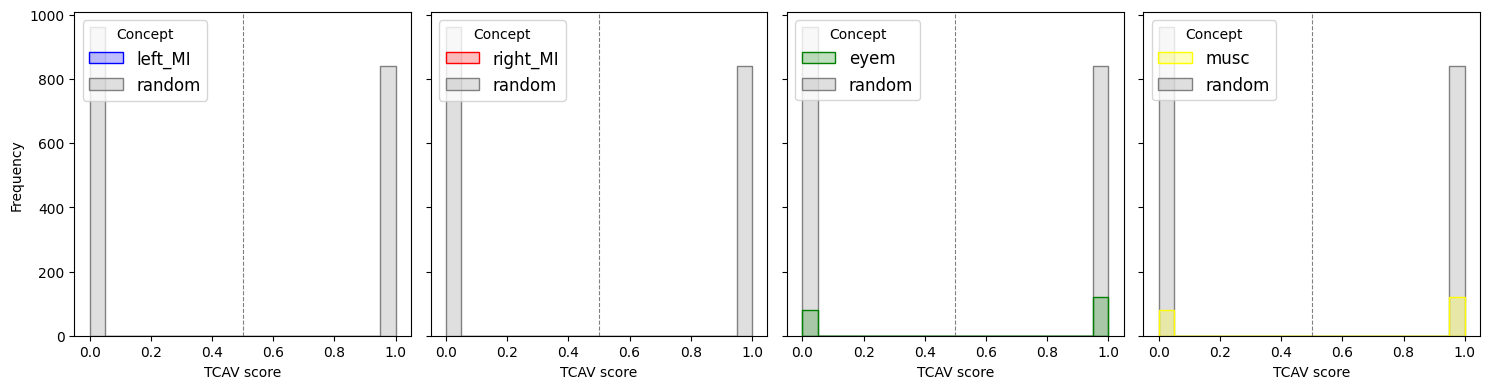

{'classifier': {'random_p-value': [0.4666666666666667, 0.49888765156985887],
  'bn_vals': [0.01, 0.01],
  'bn_stds': [0, 0],
  'significant': [False, False],
  'p-value': [0.4284498555737857, 0.4284498555737857],
  'concept': ['eyem', 'musc']}}

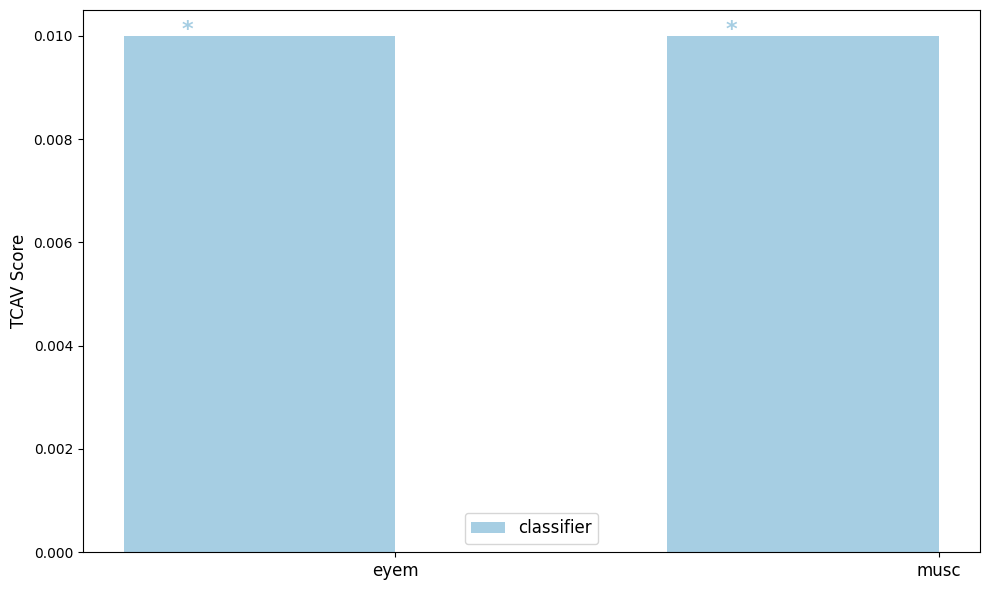

In [13]:
utils_plot.plot_results(results, num_random_exp=num_random_exp, plot_hist= True,  save_fig = False, nameOfDataFrame = result_name )